In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
user_df = pd.read_csv(r"C:\Users\dkk\AINE AI - Intern\Cookie-Cats\cookie_cats.csv")

#data types of data
print("Data types for the data set:")
user_df.dtypes

#dimension of data 
print("Shape of the data i.e. no. of rows and columns")
user_df.shape

#first 5 rows of the data
print("First 5 rows of the raw data:")
user_df.head(5)

Data types for the data set:


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Shape of the data i.e. no. of rows and columns


(90189, 5)

First 5 rows of the raw data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
user_df.isnull()

,userid,version,sum_gamerounds,retention_1,retention_7
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
90184,False,False,False,False,False
90185,False,False,False,False,False
90186,False,False,False,False,False
90187,False,False,False,False,False


In [4]:
user_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

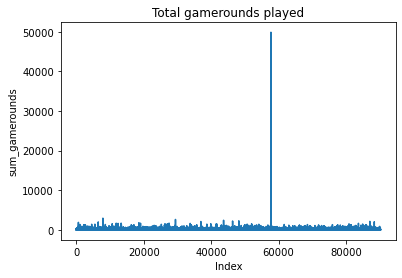

In [5]:
#Check for outlier values in sum_gamerounds column
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

In [6]:
user_df.sum_gamerounds.max()

49854

In [7]:
index = user_df.index
condition = (user_df["sum_gamerounds"] == user_df.sum_gamerounds.max())

outliers = index[condition]

print(outliers)

Int64Index([57702], dtype='int64')


In [8]:
user_df = user_df.drop(index=57702)
user_df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

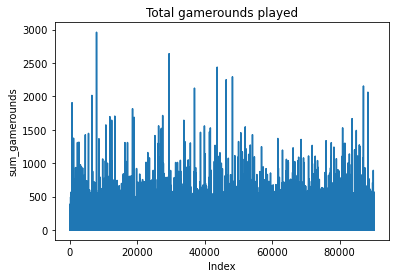

In [9]:
#Check for outlier values in sum_gamerounds column
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

In [10]:
#Insert calculation for 7-day retention rate

retention_rate_7 = (user_df['retention_7'].mean())*100
print("Overal 7 days retention rate of the game for both versions is: " ,retention_rate_7,"%")

Overal 7 days retention rate of the game for both versions is:  18.60557945624695 %


In [11]:
sumgameround_zero = len(user_df[user_df.sum_gamerounds == 0].index)
sumgameround_zero

3994

<AxesSubplot:xlabel='sum_gamerounds'>

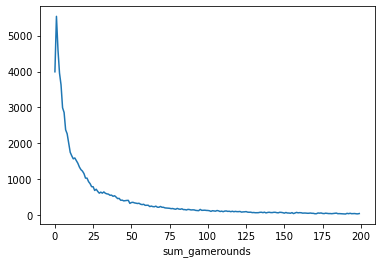

In [12]:
user_df.groupby("sum_gamerounds").userid.count()[:200].plot()

In [13]:
#cross tab for game version and retention_7 flag counting number of users for each possible categories

pd.crosstab(user_df.version, user_df.retention_7).apply(lambda r: r/r.sum(), axis=1)

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


In [14]:
user_df.groupby("version").sum_gamerounds.agg(["count","mean"])

,count,mean
version,,
gate_30,44699,51.342111
gate_40,45489,51.298776


In [15]:
#Define A/B groups for hypothesis testing
user_df["version"] = np.where(user_df.version == "gate_30", "A", "B")
group_A=pd.DataFrame(user_df[user_df.version=="A"]['sum_gamerounds'])
group_B=pd.DataFrame(user_df[user_df.version=="B"]['sum_gamerounds'])

In [16]:
normalityOfA = shapiro(group_A)[1] < 0.05
normalityOfB = shapiro(group_B)[1] < 0.05

normalityOfA

True

In [17]:
normalityOfB

True

In [18]:
def levene_Test(dataframe, group, target):
    if (normalityOfA == False) & (normalityOfB == False):

            # Assumption: Homogeneity of variances
        leveneTest = stats.levene(group_A, group_B)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True

        if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(group_A, group_B, equal_var=True)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
        else:
                # Heterogeneous
                ttest = stats.ttest_ind(group_A, group_B, equal_var=False)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
    else:
            # Non-Parametric Test
        ttest = stats.mannwhitneyu(group_A, group_B)[1] 
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
            
             # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((normalityOfA == False) & (normalityOfB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

        # Columns
    if (normalityOfA == False) & (normalityOfB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

        # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp

In [19]:
levene_Test(dataframe=user_df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!


In [20]:
def twosample_Test(dataframe, group, target):
    if (normalityOfA == False) & (normalityOfB == False):

            # Assumption: Homogeneity of variances
        twosampleTest = stests.ztest(group_A, group_B)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True

        if twosampleTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(group_A, group_B, equal_var=True)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
        else:
                # Heterogeneous
                ttest = stats.ttest_ind(group_A, group_B, equal_var=False)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
    else:
            # Non-Parametric Test
        ttest = stats.mannwhitneyu(group_A, group_B)[1] 
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True

        # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    
    temp["Test Type"] = np.where((normalityOfA == False) & (normalityOfB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

        # Columns
    if (normalityOfA == False) & (normalityOfB == False):
        temp["Homogeneity"] = np.where(twosample_Test == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

        # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

In [21]:
twosample_Test(dataframe=user_df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!


In [22]:
# Calculating 1-day and 7-days retention for each A/B group
user_df_retention_ab = user_df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
user_df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
A,44699,0.448198,0.190183,2294941
B,45489,0.442283,0.182000,2333530


<AxesSubplot:ylabel='Density'>

Text(0.5, 0, 'retantion rate')

Text(0, 0.5, 'number of sample')

Text(0.5, 1.0, '1 day retention rate distribution')

<AxesSubplot:ylabel='Density'>

Text(0.5, 0, 'retantion rate')

Text(0.5, 1.0, '7 days retention rate distribution')

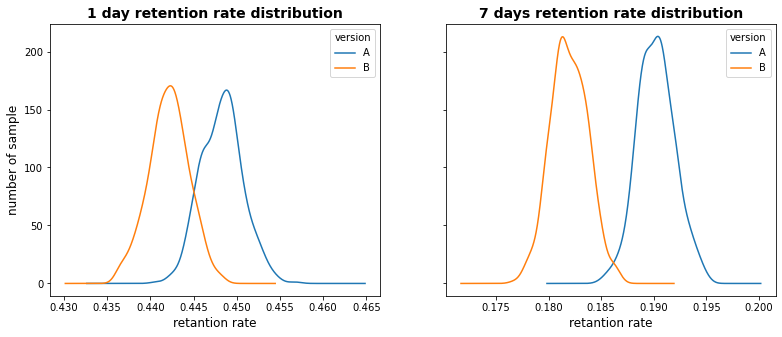

In [23]:
reten_1d = []
reten_7d = []
for i in range(500):
    reten_mean_1 = user_df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    reten_mean_7 = user_df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    reten_1d.append(reten_mean_1)
    reten_7d.append(reten_mean_7)
    
# Transforming the list to a DataFrame
reten_1d = pd.DataFrame(reten_1d)
reten_7d = pd.DataFrame(reten_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

reten_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

reten_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

Text(0.5, 0, '% difference')

Text(0, 0.5, '% density')

Text(0.5, 1.0, 'Difference in retention \n between the two A/B groups')

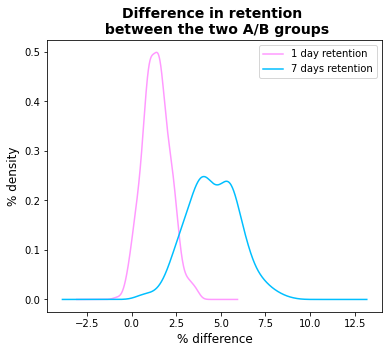

In [24]:
reten_1d['diff'] = ((reten_1d['A'] - reten_1d['B']) / reten_1d['B'] * 100)
reten_7d['diff'] = ((reten_7d['A'] - reten_7d['B']) / reten_7d['B'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

reten_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
reten_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [25]:
#the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (reten_1d['diff']>0).sum()/len(reten_1d['diff'])

#the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (reten_7d['diff']>0).sum()/len(reten_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {(prob_1)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 97.39999999999999%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 
